In [40]:
import numpy as np
import import_ipynb
from NN import get_dataset, get_model, get_shape, set_shape, get_con_mat
from keras.losses import BinaryCrossentropy
from tensorflow import cast, int32
import matplotlib.pyplot as plt
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
best_callBack = np.asarray([])

In [4]:
def inverse_probability(epsilon, x_0, x_min, x_max):
    y = np.random.random(len(x_min))
    a = (x_max - x_0) / epsilon
    b = (x_min - x_0) / epsilon
    return epsilon * np.tan(y * np.arctan(a) + (1.0 - y) * np.arctan(b)) + x_0

def __dispersion(length, initial_population_size,dispersion_a, dispersion_b):
    kk = length - 100 + 1
    return kk ** (-dispersion_a - dispersion_b * kk)

In [5]:
def SoFA( fitFunction, bounds, scbd = 0.01, initial_population_size = 100, max_iter = 10000
         , verbose = True):
    points = [np.random.uniform(bounds[:, 0],bounds[:, 1],len(bounds)) for i in range(initial_population_size)]
    fitnesses = np.asarray([fitFunction(_) for _ in points])
    fittestValue = np.max(fitnesses)
    worestValue = np.min(fitnesses)
    fittestPoint = points[np.argmax(fitnesses)]
    width = fittestValue - worestValue
    numerator = ((fitnesses-worestValue) / width) ** len(fitnesses)
    denominator = np.sum(numerator)
    probabilities = numerator / denominator
    probabilities =  np.absolute(probabilities)
    dispersion_a = 0.4
    dispersion_b = 2.5e-6
    counter = 0
    epsilon = __dispersion(len(points), initial_population_size,dispersion_a, dispersion_b)
    LossHistory = list()
    while(epsilon>=scbd and counter < max_iter):
        counter +=1
        index = np.random.choice(len(points), p=probabilities)
        newPoint = inverse_probability(epsilon,points[index],bounds[:, 0],bounds[:, 1])
        newFitness = fitFunction(newPoint)
        points.append(newPoint) 
        fitnesses = np.insert(fitnesses,len(fitnesses),newFitness)
        if newFitness > fittestValue :
            fittestPoint = newPoint
            best_callBack = newPoint
            fittestValue = newFitness
            if verbose:
                print("iteration %d : %f chosen = %f" % (counter, -fittestValue, -fitnesses[index]))
        elif newFitness < worestValue :
            worestValue = newFitness
        LossHistory.append(fittestValue)
        width = fittestValue - worestValue
        numerator = ((fitnesses-worestValue) / width) ** len(fitnesses)
        denominator = np.sum(numerator)
        probabilities = numerator / denominator
        probabilities =  np.absolute(probabilities)
        epsilon = __dispersion(len(points), initial_population_size,dispersion_a, dispersion_b)
    return [fittestPoint, fittestValue, LossHistory]

In [17]:
X_train, X_test, y_train, y_test = get_dataset()

In [18]:
model = get_model()
model.compile(loss = 'binary_crossentropy', metrics=['accuracy'])

In [19]:
shapes = get_shape(model)

In [20]:
def loss_fun(weights) :
    model.set_weights(set_shape(weights, shapes))
    loss = BinaryCrossentropy()
    predictions =  model(X_train, training=True).numpy().flatten()
    value = loss(y_train, predictions).numpy()
    return -value

In [43]:
def get_con_mat(model,X,Y):
    y_pred = model.predict(X_test)
    y_pred_binary = cast(y_pred > 0.5, dtype=int32).numpy()
    con_1 = confusion_matrix(Y, y_pred_binary)
    plt.style.use('seaborn-deep')
    plt.figure(figsize=(5,5))
    sns.heatmap(con_1, annot=True, fmt="d", cmap="Blues")
    plt.title('Churn confusion matrix\n',fontweight='bold',fontsize=15)
    plt.show()

In [22]:
limits = [0.522,0.1,0.522,0.1,0.707,0.1]

In [23]:
numbers = []
for shape in shapes:
    numbers.append(np.prod(shape))

In [24]:
max_=np.asarray([])
for i,j in zip(limits,numbers):
    temp = np.asarray([i for _ in range(j)])
    max_ = np.concatenate((max_, temp), axis=None)
min_= max_ * -1
bounds=np.asarray([(i,j) for i,j in zip(min_,max_)])

In [45]:
result=SoFA(loss_fun,bounds, verbose=True, max_iter = 20000)
model.set_weights(set_shape(result[0], shapes))
model.evaluate(X_test,y_test)

iteration 17 : 0.530623 chosen = 0.551095
iteration 53 : 0.522380 chosen = 0.550005
iteration 61 : 0.518928 chosen = 0.522380
iteration 67 : 0.515836 chosen = 0.518928
iteration 85 : 0.515553 chosen = 0.515836
iteration 90 : 0.507227 chosen = 0.515836
iteration 119 : 0.503633 chosen = 0.515553
iteration 144 : 0.502421 chosen = 0.503633
iteration 172 : 0.487962 chosen = 0.503633
iteration 188 : 0.482712 chosen = 0.487962
iteration 266 : 0.480284 chosen = 0.484364
iteration 334 : 0.471570 chosen = 0.480284
iteration 338 : 0.468356 chosen = 0.471570
iteration 373 : 0.466204 chosen = 0.468356
iteration 495 : 0.464380 chosen = 0.466204
iteration 701 : 0.462679 chosen = 0.464807
iteration 1102 : 0.461676 chosen = 0.463071
iteration 1414 : 0.459557 chosen = 0.461676
iteration 1447 : 0.451988 chosen = 0.460422
iteration 1522 : 0.450876 chosen = 0.451988
iteration 1533 : 0.449846 chosen = 0.450876
iteration 2129 : 0.449475 chosen = 0.449846
iteration 2457 : 0.446549 chosen = 0.449475
iteration 

[0.38339629769325256, 0.8395000100135803]

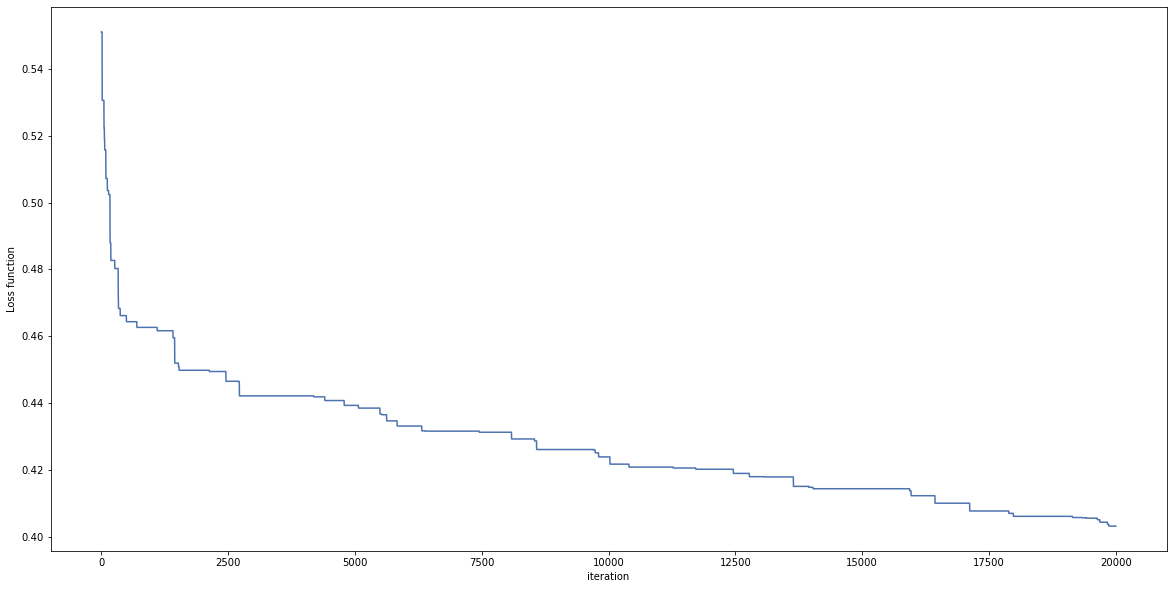

In [46]:
plotting = np.absolute(result[2])
plt.figure(figsize=(20,10))
plt.plot(np.arange(20000),plotting)
plt.xlabel("iteration")
plt.ylabel("Loss function")
plt.show()

In [34]:
my_list = np.array(result[2])
my_list = my_list.tolist()
with open("test/sofa.json", "w") as f:
    json.dump(my_list, f)

In [6]:
def obj(x):
    return -((x[0]+2*x[1]-7)**2+(2*x[0]+x[1]-5)**2)

In [7]:
bounds_ = np.asarray([(-10.0, 10.0), (-10.0, 10.0)])

In [14]:
obj_result=SoFA(obj,bounds_,max_iter = 1000)

iteration 14 : 3.037206 chosen = 4.592918
iteration 15 : 2.798684 chosen = 11.593808
iteration 19 : 2.385098 chosen = 4.592918
iteration 25 : 0.828985 chosen = 3.037206
iteration 135 : 0.075472 chosen = 4.245251
iteration 192 : 0.068768 chosen = 0.075472
iteration 286 : 0.013334 chosen = 0.068768
iteration 834 : 0.008988 chosen = 0.022551
iteration 903 : 0.008363 chosen = 0.016756
iteration 956 : 0.004037 chosen = 0.016126


In [15]:
my_list = np.array(obj_result[2])
my_list = my_list.tolist()
with open("test/obj.json", "w") as f:
    json.dump(my_list, f)

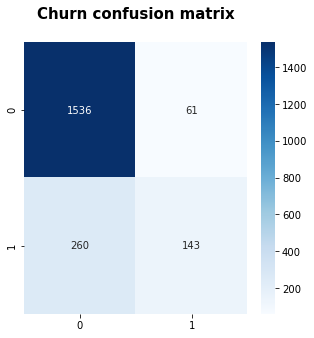

In [47]:
get_con_mat(model, X_test, y_test)

In [48]:
len(X_train)

8000

In [49]:
y_pred = model.predict(X_test)
y_pred_binary = cast(y_pred > 0.5, dtype=int32).numpy()
con_1 = confusion_matrix(y_test, y_pred_binary)

In [50]:
con_1

array([[1536,   61],
       [ 260,  143]], dtype=int64)